## ПЗ 6. Не успел закончить. Можно доделать до 14.06.21?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math
from tqdm import tqdm_notebook, tqdm
from skimage.draw import ellipse, polygon

import tensorflow as tf

from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout
from tensorflow.keras.losses import binary_crossentropy

import keras as keras

from tensorflow.keras import backend as K

from tqdm import tqdm_notebook
w_size = 256
train_num = 8192
train_x = np.zeros((train_num, w_size, w_size,3), dtype='float32')
train_y = np.zeros((train_num, w_size, w_size,1), dtype='float32')

img_l = np.random.sample((w_size, w_size, 3))*0.5
img_h = np.random.sample((w_size, w_size, 3))*0.5 + 0.5

radius_min = 10
radius_max = 30


In [2]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def get_iou_vector(A, B):
    # Numpy version
    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric

def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)

from keras.utils.generic_utils import get_custom_objects

get_custom_objects().update({'bce_dice_loss': bce_dice_loss })
get_custom_objects().update({'dice_loss': dice_loss })
get_custom_objects().update({'dice_coef': dice_coef })
get_custom_objects().update({'my_iou_metric': my_iou_metric })

In [3]:
def next_pair():
    
    p = np.random.sample() - 0.5 # пока не успользуем
    # r,c - координаты центра эллипса
    r = np.random.sample()*(w_size-2*radius_max) + radius_max
    c = np.random.sample()*(w_size-2*radius_max) + radius_max
    # большой и малый радиусы эллипса
    r_radius = np.random.sample()*(radius_max-radius_min) + radius_min
    c_radius = np.random.sample()*(radius_max-radius_min) + radius_min
    rot = np.random.sample()*360 #  наклон эллипса
    rr, cc = ellipse(
      r, c, 
      r_radius, c_radius, 
      rotation=np.deg2rad(rot), 
      shape=img_l.shape
    )  # получаем все точки эллипса

    # красим пиксели моря/фона в шум от 0.5 до 1.0
    img = img_h.copy()
    # красим пиксели эллипса в шум от 0.0  до 0.5
    img[rr, cc] = img_l[rr, cc]
    
    msk = np.zeros((w_size, w_size, 1), dtype='float32')
    msk[rr, cc] = 1. # красим пиксели маски эллипса

    return img, msk

In [4]:
def build_model(input_layer, start_neurons):
    conv1 = Conv2D(start_neurons*1,(3,3),activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons*1,(3,3),activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons*2,(3,3),activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons*2,(3,3),activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons*4,(3,3),activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons*4,(3,3),activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons*8,(3,3),activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons*8,(3,3),activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons*16,(3,3),activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons*16,(3,3),activation="relu", padding="same")(convm)

    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons*8,(3,3),activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons*8,(3,3),activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons*4,(3,3),strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons*4,(3,3),activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons*4,(3,3),activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons*2,(3,3),strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons*2,(3,3),activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons*2,(3,3),activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons*1,(3,3),strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons*1,(3,3),activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons*1,(3,3),activation="relu", padding="same")(uconv1)

    uncov1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1,(1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

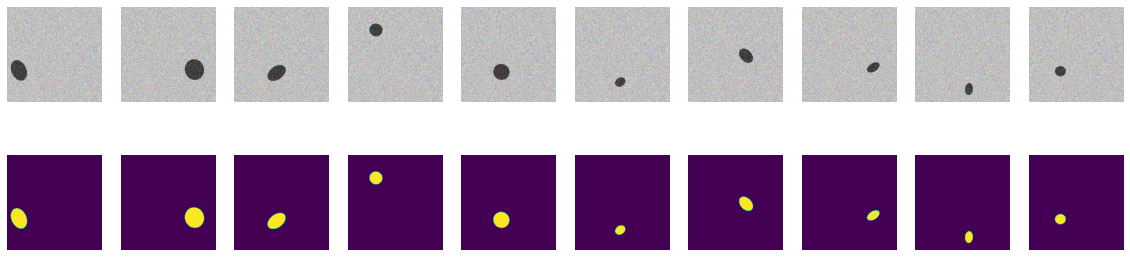

In [5]:
for k in range(train_num): # генерация всех img train
    img, msk = next_pair()
    
    train_x[k] = img
    train_y[k] = msk

fig, axes = plt.subplots(2, 10, figsize=(20, 5)) # смотрим на первые 10 с масками
for k in range(10):
    axes[0,k].set_axis_off()
    axes[0,k].imshow(train_x[k])
    axes[1,k].set_axis_off()
    axes[1,k].imshow(train_y[k].squeeze())